# Home Credit Default Risk

This is part of my capstone project on [Data Scientist nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025) at [Udacity](www.udacity.com)! \o/

Author: Douglas Trajano
> [LinkedIn](https://www.linkedin.com/in/douglas-trajano/) | [GitHub](https://github.com/DougTrajano)

---

# // objective

> Can you predict how capable each applicant is of repaying a loan?

Well, it's a binary classification between `0` and `1`. Customer can repay or not his loan?

---

# // dataset

The dataset has 7 files. All these files can be downloaded [here](https://www.kaggle.com/c/home-credit-default-risk/data)

![](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

### application_{train|test}.csv
> Size (train): 308k x 122
>
> Size (test): 48.7k x 121

- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.


### bureau.csv
> Size: 1.72m x 17

- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

### bureau_balance.csv
> Size: 27.3m x 3

- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

### POS_CASH_balance.csv
> Size: 10.0m x 8

- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

### credit_card_balance.csv
> Size: 3.84m x 23

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

### previous_application.csv
> Size: 1.67m x 37

- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

### installments_payments.csv
> Size: 13.6m x 8

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

### HomeCredit_columns_description.csv
> Size: 219 x 5

- This file contains descriptions for the columns in the various data files.

---

# // metric's definition

As metric to evaluate models I'll use [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). See below a little description about this metric.

> The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
> 
> `F1 = 2 * (precision * recall) / (precision + recall)`

Another metric that we will use is the Kaggle's Score. We have a csv file called `application_test.csv` that can be used to predict and submit to Kaggle. Kaggle will provide a score for us.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from plotly.offline import init_notebook_mode, iplot
import plotly.offline as py
import plotly.graph_objs as go
import plotly.offline as offline
py.init_notebook_mode(connected=True)
init_notebook_mode(connected=True)
offline.init_notebook_mode()
%matplotlib inline

# Sklearn and TensorFlow
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.testing import all_estimators
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/previous_application.csv


---
# // load datasets

We'll working only with `df_application_train.csv` in this study.

In [2]:
df_application_train = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
print("Shape:", df_application_train.shape)
df_application_train.head()

Shape: (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

---

# // exploratory analysis

In this part of the notebook we will explore the dataset.

We will work with `application_train.csv` because this dataset has 122 characteristics for the loans, we have 307511 loans (one loan for row).

We also has a TARGET that we will use to fit the model.

## // pandas profiling

I like to run [pandas_profiling](https://pandas-profiling.github.io/pandas-profiling/docs/) in the dataset. It's provide a lot of information about a dataset and we can do a quick analysis with it.

Because of the dataset size it could not be run on Kaggle Notebook.

I ran this on [AWS SageMaker](https://aws.amazon.com/sagemaker/) (ml.m5.24xlarge, vCPU: 96, Mem (GiB): 384GB). ¯\\_(ツ)_/¯

[dataset.overview.html](https://dougtrajano.github.io/udacity_capstone_project/dataset_overview.html)

In [3]:
df_temp = df_application_train["TARGET"].value_counts()

trace = go.Pie(
    labels = df_temp.index,
    values = df_temp.values,
)

data = [trace]

layout = go.Layout(
    title = "Loan Repayed or not",
    xaxis=dict(
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
fig.update_layout(template="seaborn")
py.iplot(fig)

> We can see that we have an imbalanced classes. We will need to work with before fit the model.

In [4]:
df_temp = df_application_train["NAME_CONTRACT_TYPE"].value_counts()

fig = {
  "data": [
    {
      "values": df_temp.values,
      "labels": df_temp.index,
      "domain": {"x": [0, .48]},
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Contract type",
    }
}

fig = go.Figure(fig)
fig.update_layout(template="seaborn")
iplot(fig)

In [5]:
df_temp = df_application_train["NAME_FAMILY_STATUS"].value_counts()

fig = {
  "data": [
    {
      "y": df_temp.values,
      "x": df_temp.index,
      "type": "bar"
    },
    
    ],
  "layout": {
        "title":"Family Status",
    }
}

fig = go.Figure(fig)
fig.update_layout(template="seaborn")
iplot(fig)

> 63,88% applicants are married.

In [6]:
df_temp = df_application_train["OCCUPATION_TYPE"].value_counts()

fig = {
  "data": [
    {
        "x": df_temp.index,
        "y": df_temp.values,
        "type": "bar"
    },
    
    ],
  "layout": {
        "title":"Occupation of applicant\'s"
    }
}

fig = go.Figure(fig)
fig.update_layout(template="seaborn")
iplot(fig)

> Top occupations and it's percentage.
> 
> - Laborers: 17,95%
> - Sales staff: 10,44%
> - Core staff: 8,97%
> - Managers: 6,95%
> - Drivers: 6,05%

In [7]:
df_temp = pd.DataFrame(df_application_train.isnull().sum().sort_values(ascending=False)/len(df_application_train), columns=["MISSING_VALUES"])
df_temp = df_temp[df_temp["MISSING_VALUES"] > 0]

fig = {
  "data": [
    {
        "x": df_temp.index,
        "y": df_temp.MISSING_VALUES.values,
        "type": "bar"
    },
    
    ],
  "layout": {
        "title":"Columns with missing values (%)"
    }
}

fig = go.Figure(fig)
fig.update_layout(template="seaborn")
iplot(fig)

We have a lot of features with missing values. We need to handle with it before create our model.

---
# // prepare dataset


In this section I'll check the best features and prepare the dataset to be used as **X** and **Y** in the modeling.

We will convert categorical features to numeric features using [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

We will remove some features that aren't important or are inappropriate for the model as well. As example, it's inappropriate to use the gender for predict if a person can pay or not the loan.

## // missing values

The strategy to handle with missing values is divided by low, medium and high quantity of missing values. For each of these we will apply a different technique to solve it.

In [8]:
# Missing values
## For low number of missing values we'll apply the mean for float64 objects and "Other" for string columns.

low_missing_values_col = ["DAYS_LAST_PHONE_CHANGE", "CNT_FAM_MEMBERS", "AMT_ANNUITY", "AMT_GOODS_PRICE", "EXT_SOURCE_2",
                          "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE",
                          "OBS_30_CNT_SOCIAL_CIRCLE", "NAME_TYPE_SUITE"]

for col in low_missing_values_col:
    if df_application_train[col].dtype == "object":
        df_application_train[col].fillna("Other", inplace=True)
    elif df_application_train[col].dtype == "float64":
        df_application_train[col].fillna(df_application_train[col].mean(), inplace=True)
    else:
        print("{} has a different dtype.".format(col))
    print("{}:".format(col), df_application_train[col].dtype)

DAYS_LAST_PHONE_CHANGE: float64
CNT_FAM_MEMBERS: float64
AMT_ANNUITY: float64
AMT_GOODS_PRICE: float64
EXT_SOURCE_2: float64
DEF_30_CNT_SOCIAL_CIRCLE: float64
DEF_60_CNT_SOCIAL_CIRCLE: float64
OBS_60_CNT_SOCIAL_CIRCLE: float64
OBS_30_CNT_SOCIAL_CIRCLE: float64
NAME_TYPE_SUITE: object


In [9]:
# Medium quantity
## The strategy for medium quantity of missing values will be remove rows with np.nan.

medium_missing_values_col = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_WEEK",
                             "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_QRT",
                            "EXT_SOURCE_3"]

print("df_application_train shape before remove missing rows:", df_application_train.shape)
    
for col in medium_missing_values_col:
    print(col, df_application_train[col].dtype)
    if col == "EXT_SOURCE_3":
        print("Mean:", df_application_train[col].mean(), "\n")
    else:
        print(df_application_train[col].unique(), "\n")

df_application_train.dropna(subset=medium_missing_values_col, inplace=True)
print("df_application_train shape after remove missing rows:", df_application_train.shape)

df_application_train shape before remove missing rows: (307511, 122)
AMT_REQ_CREDIT_BUREAU_HOUR float64
[ 0. nan  1.  2.  3.  4.] 

AMT_REQ_CREDIT_BUREAU_MON float64
[ 0. nan  1.  2.  6.  5.  3.  7.  9.  4. 11.  8. 16. 12. 14. 10. 13. 17.
 24. 19. 15. 23. 18. 27. 22.] 

AMT_REQ_CREDIT_BUREAU_WEEK float64
[ 0. nan  1.  3.  2.  4.  5.  6.  8.  7.] 

AMT_REQ_CREDIT_BUREAU_DAY float64
[ 0. nan  1.  3.  2.  4.  5.  6.  9.  8.] 

AMT_REQ_CREDIT_BUREAU_YEAR float64
[ 1.  0. nan  2.  4.  5.  3.  8.  6.  9.  7. 10. 11. 13. 16. 12. 25. 23.
 15. 14. 22. 17. 19. 18. 21. 20.] 

AMT_REQ_CREDIT_BUREAU_QRT float64
[  0.  nan   1.   2.   4.   3.   8.   5.   6.   7. 261.  19.] 

EXT_SOURCE_3 float64
Mean: 0.5108529061800121 

df_application_train shape after remove missing rows: (246546, 122)


In [10]:
# For high quantity of missing values, we'll drop these columns
df_application_train.dropna(axis="columns", how="any", inplace=True)
df_application_train.shape

(246546, 72)

In [11]:
# Check missing values
missing_values = df_application_train.isnull().sum().sum()
print("Quantiy of missing values:", missing_values)

Quantiy of missing values: 0


In [12]:
# Categorical features
df_application_train_dtypes = pd.DataFrame(df_application_train.dtypes, columns=["dtypes"])
cat_features = df_application_train_dtypes[(df_application_train_dtypes["dtypes"] == "object") | (df_application_train_dtypes["dtypes"] == "category")].index.tolist()
print("Categorical features ({}):".format(len(cat_features)), cat_features)

Categorical features (11): ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


In [13]:
from sklearn.preprocessing import LabelEncoder

# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
df_application_train[cat_features] = df_application_train[cat_features].apply(lambda col: le.fit_transform(col))
df_application_train.loc[:][cat_features].head(10)

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                    0            1             0                1   
2                    1            1             1                1   
5                    0            1             0                1   
6                    0            0             1                1   
7                    0            1             1                1   
8                    0            0             0                1   
10                   0            0             0                1   
11                   0            0             0                1   
12                   0            0             0                1   
13                   0            1             1                0   

    NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0                 7                 6                    4   
2                 7                 6                    4   
5                 6                 3                    4   
6                 7                 1                    1   
7                 7                 3                    1   
8                 0                 2                    4   
10                7                 6                    1   
11                0                 2                    4   
12                7                 6                    4   
13                7                 6                    4   

    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  WEEKDAY_APPR_PROCESS_START  \
0                    3                  1                           6   
2                    3                  1                           1   
5                    1                  1                           6   
6                    1                  1                           3   
7                    1                  1                           1   
8                    1                  1                           6   
10                   1                  1                           2   
11                   1                  1                           0   
12                   1                  1                           0   
13                   1                  1                           4   

    ORGANIZATION_TYPE  
0                   5  
2                  11  
5                  33  
6                   5  
7                  33  
8                  57  
10                 30  
11                 57  
12                  4  
13                 42

In [14]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_application_train.corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

In [15]:
#Correlation with TARGET variable
cor_target = abs(cor["TARGET"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05].sort_values(ascending=False)
relevant_features[1:]

EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.153856
DAYS_BIRTH                     0.078807
REGION_RATING_CLIENT_W_CITY    0.056488
REGION_RATING_CLIENT           0.054481
DAYS_LAST_PHONE_CHANGE         0.051290
NAME_EDUCATION_TYPE            0.051161
CODE_GENDER                    0.050963
Name: TARGET, dtype: float64

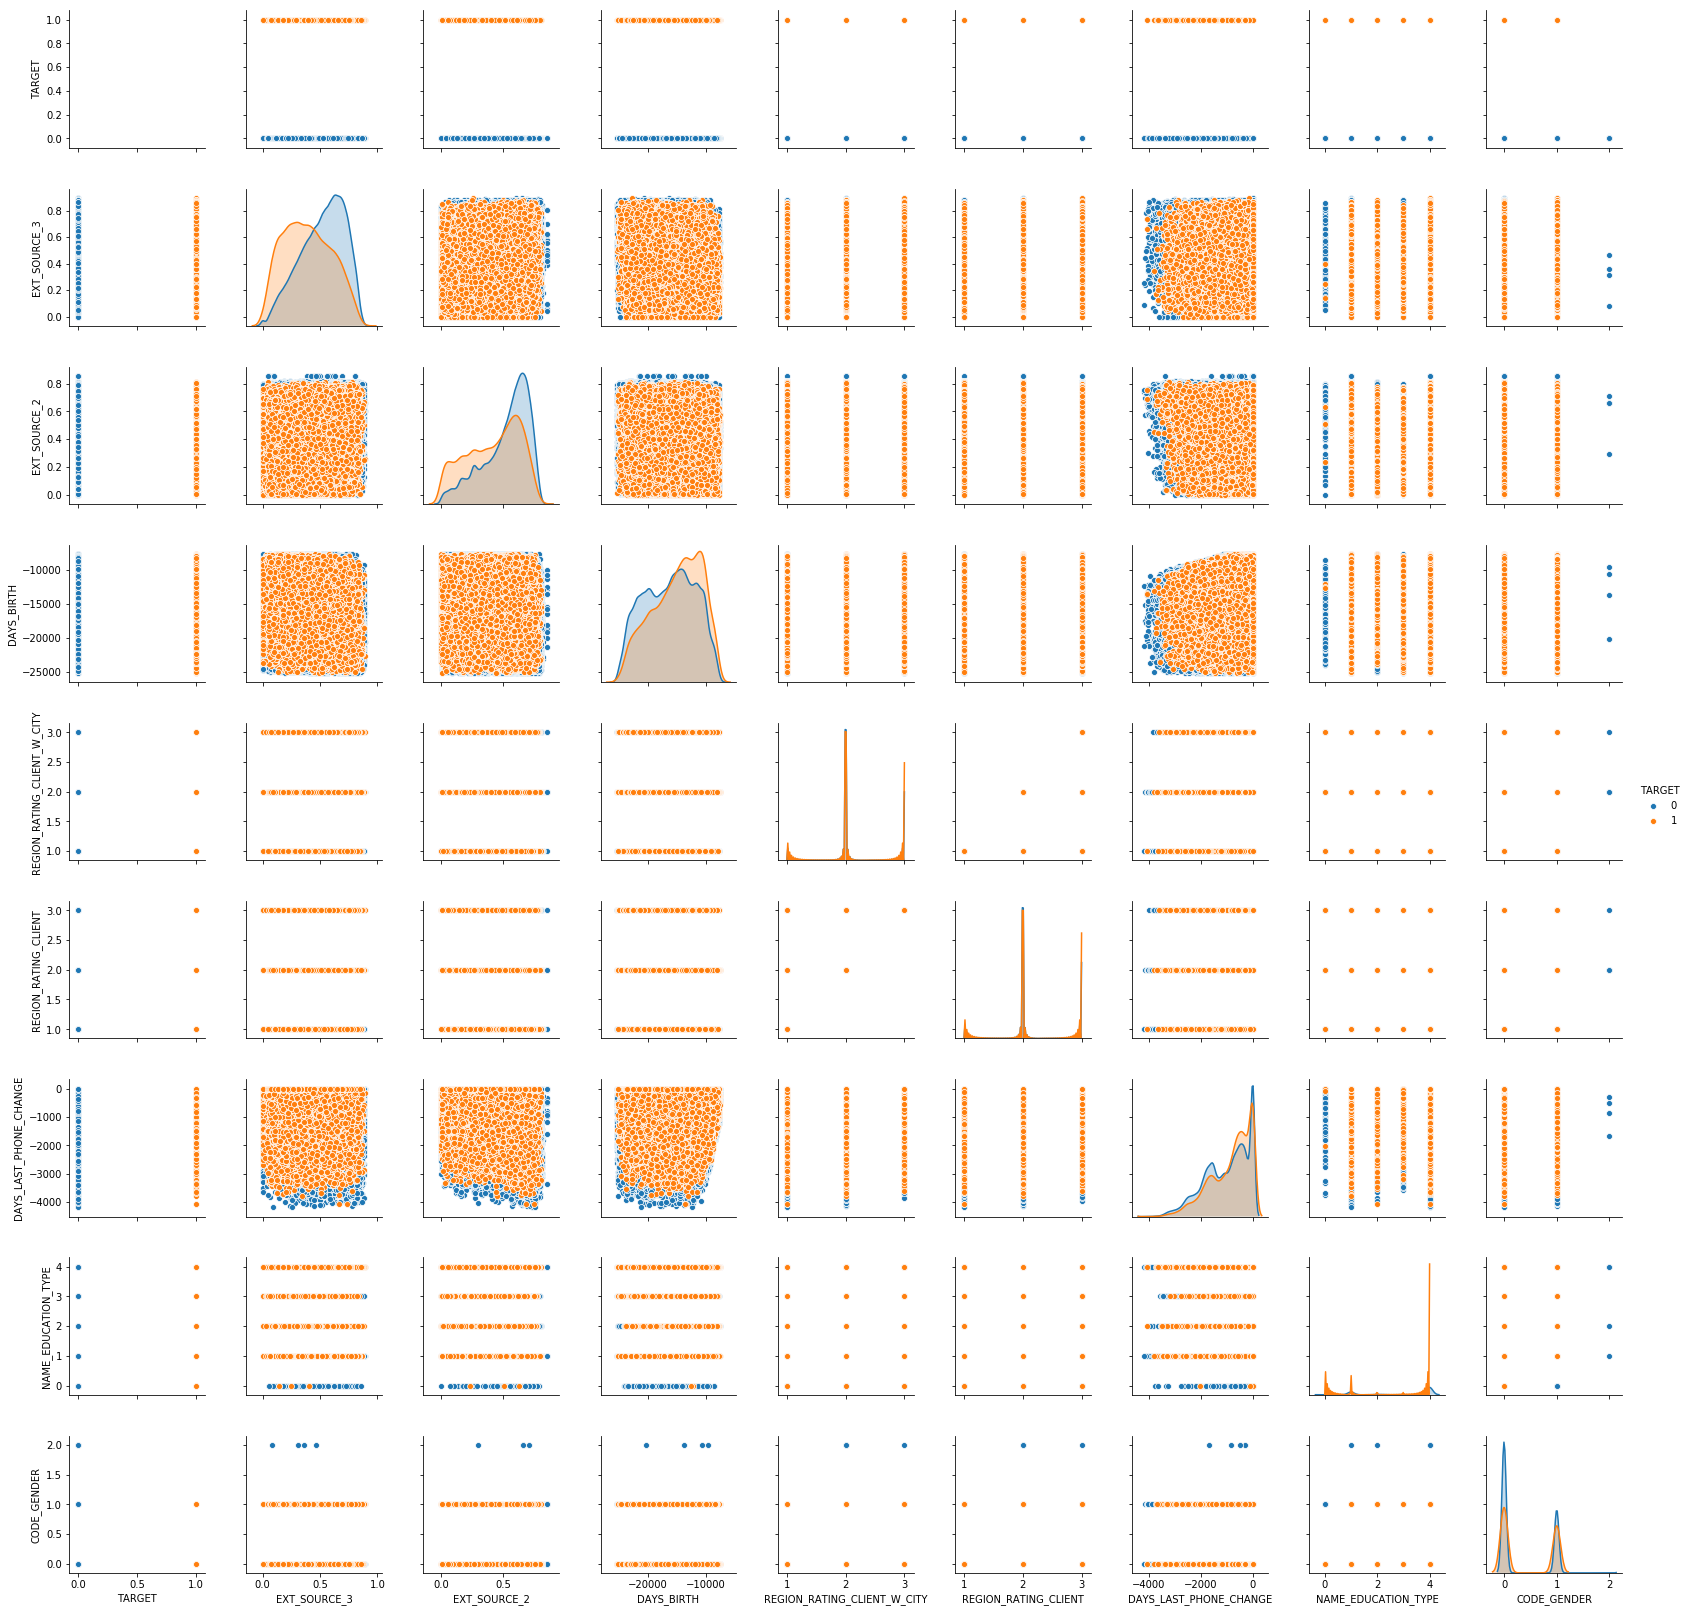

In [16]:
# Pairplot only for relevant_features
sns.pairplot(df_application_train, hue="TARGET", vars=relevant_features.index.tolist())
plt.show()

In [17]:
# Split in X and Y and apply MinMaxScaler (0, 1)

X = df_application_train.drop(columns=["SK_ID_CURR", "TARGET"])
y = df_application_train["TARGET"].values

scaler = MinMaxScaler()
X = scaler.fit_transform(X.values)

print("X shape:", X.shape)

X shape: (246546, 70)


---

# // PCA

Now we have 70 features in the X. Can we apply a dimensionality reduction technique?

Yes! PCA (Principal Component Analysis) can discovery it for us what importance each feature has in the dataset.

In [18]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
    #    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca, X_pca = do_pca(X.shape[1], X)
X_pca = None #just cleaning memory
scree_plot(pca)

In [19]:
n_components = 40
pca, X_pca = do_pca(n_components, X)

print("Explained variance for {} components: {:.2f}%".format(n_components, sum(pca.explained_variance_ratio_)*100))

Explained variance for 40 components: 80.48%


In [20]:
print("PCA: Top 10 Explained variance", "\n")
for i in range(len(pca.explained_variance_ratio_[:10])):
    print("component {}: {:.2f}%".format(i+1, pca.explained_variance_ratio_[i]*100))

PCA: Top 10 Explained variance 

component 1: 7.14%
component 2: 4.95%
component 3: 3.86%
component 4: 3.65%
component 5: 3.24%
component 6: 2.94%
component 7: 2.53%
component 8: 2.19%
component 9: 2.10%
component 10: 2.05%


---

# // modeling

I tried build model with commum machine learning algorithms (LogisticRegression, RandomForestClassifier, etc.) and neural networks with TensorFlow/Keras.

See below the best results for this dataset.

In [21]:
# Split the dataset in train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("train size:", len(X_train))
print("test size:", len(X_test))

train size: 165185
test size: 81361


> Handling unbalanced classes

In [22]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

class_weights = {
    0: class_weights[0],
    1: class_weights[1]
}

class_weights

{0: 0.542426033559912, 1: 6.392608359133127}

> What sklearn algorithms has **class_weight** as attribute?

In [23]:
print("Sklearn's classifier algorithms with class_weight attribute:", "\n")
estimators = all_estimators(type_filter='classifier')
for name, class_ in estimators:
    try:
        if hasattr(class_(), 'class_weight'): 
            print(name)
    except:
        pass

Sklearn's classifier algorithms with class_weight attribute: 

DecisionTreeClassifier
ExtraTreeClassifier
ExtraTreesClassifier
LinearSVC
LogisticRegression
LogisticRegressionCV
NuSVC
PassiveAggressiveClassifier
Perceptron
RandomForestClassifier
RidgeClassifier
RidgeClassifierCV
SGDClassifier
SVC


[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [24]:
%%time
clf_log = LogisticRegression(solver="liblinear", class_weight=class_weights)
clf_log.fit(X_train, y_train)

y_pred = clf_log.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9621    0.6913    0.8046     75133
           1     0.1528    0.6718    0.2490      6228

    accuracy                         0.6898     81361
   macro avg     0.5575    0.6816    0.5268     81361
weighted avg     0.9002    0.6898    0.7620     81361

CPU times: user 12.6 s, sys: 16 ms, total: 12.6 s
Wall time: 12.7 s


[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [25]:
%%time
clf_rf = RandomForestClassifier(n_estimators=50, class_weight=class_weights, n_jobs=-1, min_samples_leaf=200, max_depth=30)
clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9596    0.7272    0.8274     75133
           1     0.1609    0.6309    0.2564      6228

    accuracy                         0.7198     81361
   macro avg     0.5602    0.6790    0.5419     81361
weighted avg     0.8985    0.7198    0.7837     81361

CPU times: user 24.9 s, sys: 68 ms, total: 25 s
Wall time: 13.3 s


In [26]:
%%time
# GridSearch for RandomForestClassifier
model = RandomForestClassifier(class_weight=class_weights)

parameters = {
    "n_estimators": [10, 30, 50, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [10, 20, 30],
    "min_samples_leaf": [50, 100, 200]    
}

clf_rf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=1)
clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)
print(clf_rf.best_estimator_)
print("\n\n")
print(classification_report(y_test, y_pred, digits=4))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 63.9min finished


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.542426033559912,
                                     1: 6.392608359133127},
                       criterion='entropy', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=50,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)



              precision    recall  f1-score   support

           0     0.9538    0.8110    0.8766     75133
           1     0.1874    0.5259    0.2763      6228

    accuracy                         0.7892     81361
   macro avg     0.5706    0.6684    0.5765     81361
weighted avg     0.8951    0.7892    0.8307     81361

CPU times: user 52.3 s, sys: 700 ms, total: 53 s
Wall time: 1h 4min 42s


[LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [27]:
%%time
from lightgbm import LGBMClassifier
clf_lgbmc = LGBMClassifier(objective='binary', metric='auc', class_weight=class_weights, n_estimators=1000, max_depth=20)

clf_lgbmc.fit(X_train, y_train,
              eval_set = [(X_test, y_test)],
              early_stopping_rounds=50,
              verbose=0)

y_pred = clf_lgbmc.predict(X_test, num_iteration=clf_lgbmc.best_iteration_)
print("\n\n")
print(classification_report(y_test, y_pred, digits=4))




              precision    recall  f1-score   support

           0     0.9622    0.7194    0.8233     75133
           1     0.1630    0.6593    0.2614      6228

    accuracy                         0.7148     81361
   macro avg     0.5626    0.6893    0.5423     81361
weighted avg     0.9010    0.7148    0.7803     81361

CPU times: user 16.7 s, sys: 312 ms, total: 17 s
Wall time: 8.98 s


In [28]:
%%time
# GridSearch for LGBMClassifier
model = LGBMClassifier(class_weight=class_weights, objective='binary', metric='auc')
    
parameters = {
    "n_estimators": [100, 300, 500, 1000],
    "boosting_type": ["gbdt", "dart", "goss"],
    "max_depth": [10, 20, 30] 
}

clf_lgbmc = GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=1)
clf_lgbmc.fit(X_train, y_train)

y_pred = clf_lgbmc.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 305.4min finished


              precision    recall  f1-score   support

           0     0.9498    0.8401    0.8916     75133
           1     0.1942    0.4648    0.2740      6228

    accuracy                         0.8114     81361
   macro avg     0.5720    0.6525    0.5828     81361
weighted avg     0.8920    0.8114    0.8443     81361

CPU times: user 1min 5s, sys: 3.08 s, total: 1min 9s
Wall time: 5h 6min


[TensorFlow](https://www.tensorflow.org)/[Keras](http://keras.io)

In [29]:
%%time
import keras.backend as K

X_train_k = X_train
y_train_k = np.array(y_train)

X_test_k = X_test
y_test_k = np.array(y_test)

def f1_keras(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2*precision*recall / (precision+recall+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# TensorFlow/Keras
clf_keras = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, input_dim=X_train_k.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
    
clf_keras.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy", f1_keras])

clf_keras.fit(X_train_k, y_train_k, epochs=50, class_weight=class_weights, use_multiprocessing=True, batch_size=128)

model_evals = clf_keras.evaluate(X_test_k, y_test_k)

print("\n")
print("Evaluate Model")
print("Loss: {}".format(model_evals[0]))
print("Accuracy: {}".format(model_evals[1]))
print("F1-Score: {}".format(model_evals[2]))

Using TensorFlow backend.


Epoch 1/50
165185/165185 [==============================] - 6s 33us/sample - loss: 0.6321 - acc: 0.6518 - f1_keras: 0.2263
Epoch 2/50
165185/165185 [==============================] - 5s 30us/sample - loss: 0.6143 - acc: 0.6842 - f1_keras: 0.2460
Epoch 3/50
165185/165185 [==============================] - 5s 30us/sample - loss: 0.6103 - acc: 0.6864 - f1_keras: 0.2488
Epoch 4/50
165185/165185 [==============================] - 5s 30us/sample - loss: 0.6075 - acc: 0.6849 - f1_keras: 0.2480
Epoch 5/50
165185/165185 [==============================] - 5s 30us/sample - loss: 0.6082 - acc: 0.6820 - f1_keras: 0.2485
Epoch 6/50
165185/165185 [==============================] - 5s 30us/sample - loss: 0.6079 - acc: 0.6870 - f1_keras: 0.2504
Epoch 7/50
165185/165185 [==============================] - 5s 30us/sample - loss: 0.6046 - acc: 0.6820 - f1_keras: 0.2477
Epoch 8/50
165185/165185 [==============================] - 5s 30us/sample - loss: 0.6054 - acc: 0.6782 - f1_keras: 0.2481
Epoch 9/50
16518

In [30]:
clf_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               36352     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [31]:
def shame_function(y_pred):
    """
    This function update y_pred for 1 or 0.
    
    I think that have a better solution for that, but I don't find anything at this time.
    """
    result = []
    for n in y_pred:
        if n[0] >= 0.5:
            result.append(1)
        else:
            result.append(0)
    return result

y_pred = shame_function(clf_keras.predict(X_test))

print("y_test")
print("% of target == 1: {:.2f}%".format((len(y_test.tolist())/sum(y_test.tolist()))))
print(y_test.tolist()[:10])
print("\n")
print("y_pred")
print("% of target == 1: {:.2f}%".format((len(y_pred)/sum(y_pred))))
print(y_pred[:10])

y_test
% of target == 1: 13.06%
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


y_pred
% of target == 1: 3.42%
[1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


---

# // submission

In this section I'll create a submission.csv file to send to the Leaderboard.

In [32]:
def preprocessing(df, n_components=None, return_pca=False):
    # Missing values
    low_missing_values_col = ["DAYS_LAST_PHONE_CHANGE", "CNT_FAM_MEMBERS", "AMT_ANNUITY", "AMT_GOODS_PRICE", "EXT_SOURCE_2",
                              "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE",
                              "OBS_30_CNT_SOCIAL_CIRCLE", "NAME_TYPE_SUITE"]

    for col in low_missing_values_col:
        if df[col].dtype == "object":
            df[col].fillna("Other", inplace=True)
        elif df[col].dtype == "float64":
            df[col].fillna(df[col].mean(), inplace=True)


    medium_missing_values_col = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_WEEK",
                                 "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_QRT",
                                "EXT_SOURCE_3"]

    for col in medium_missing_values_col:
        if df[col].dtype == "object":
            df[col].fillna("Other", inplace=True)
        elif df[col].dtype == "float64":
            df[col].fillna(df[col].mean(), inplace=True)
            
    df.dropna(axis="columns", how="any", inplace=True)
    
    # Split in X and Y
    X = df.dropna(axis="columns", how="any")
    X.drop(columns=["SK_ID_CURR", "TARGET"], inplace=True, errors="ignore")

    try:
        y = df["TARGET"].values
    except:
        y = None
        print("TARGET column not found.")
    
    X_dtypes = pd.DataFrame(X.dtypes, columns=["dtypes"])
    cat_features = X_dtypes[(X_dtypes["dtypes"] == "object") | (X_dtypes["dtypes"] == "category")].index.tolist()
    
    # instantiate labelencoder object
    le = LabelEncoder()
    # apply le on categorical feature columns
    X[cat_features] = X[cat_features].apply(lambda col: le.fit_transform(col))
    X.loc[:][cat_features].head(10)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X.values)

    if n_components == None:
        n_components = X.shape[1]
        
    pca, X_pca = do_pca(n_components, X)
    
    if y != None and return_pca != False:
        return X_pca, y
    elif y != None and return_pca == True:
        return X_pca, y, pca
    elif y == None and return_pca == True:
        return X_pca, pca
    else:
        return X_pca

def submission_file(model, keras_model=False, n_components=70, filename="submission.csv"):
    """
    Args
    
    model: Model to predict
    keras_model: True/False if we are using Keras Model or not.
    n_components: To preprocessing PCA.
    
    Return
    Link to submission file download.
    """
    from IPython.display import FileLink
    
    df_application_test = pd.read_csv("/kaggle/input/home-credit-default-risk/application_test.csv")
    submission = preprocessing(df_application_test, n_components=n_components)

    if keras_model:
        predicts = shame_function(model.predict(submission))
    else:
        predicts = model.predict(submission)

    df_sample_submission = pd.read_csv("/kaggle/input/home-credit-default-risk/sample_submission.csv")
    df_sample_submission["TARGET"] = predicts

    df_sample_submission.to_csv(filename, index=False)
    print("{} salved.".format(filename))
    return FileLink(r'{}'.format(filename))

In [33]:
# LogisticRegression
submission_file(clf_log, n_components=70,
                filename="submission_LogisticRegression.csv")

TARGET column not found.
submission_LogisticRegression.csv salved.


/kaggle/working/submission_LogisticRegression.csv

In [34]:
# RandomForest
submission_file(clf_rf, n_components=70,
                filename="submission_RandomForest.csv")

TARGET column not found.
submission_RandomForest.csv salved.


/kaggle/working/submission_RandomForest.csv

In [35]:
# LGBMClassifier
submission_file(clf_lgbmc, n_components=70,
                filename="submission_LGBMClassifier.csv")

TARGET column not found.
submission_LGBMClassifier.csv salved.


/kaggle/working/submission_LGBMClassifier.csv

In [36]:
# TensorFlow/Keras
submission_file(clf_keras, keras_model=True, n_components=70,
                filename="submission_TensorFlow-Keras.csv")

TARGET column not found.
submission_TensorFlow-Keras.csv salved.


/kaggle/working/submission_TensorFlow-Keras.csv

---
# // results

You can see the complete result in the [medium post](https://medium.com/@dougtrajano/ia-applied-in-credit-risk-home-credit-b70412ef8f02).